# 1-D Heat Conduction (FTCS) — Copper Fin Demo

We solve 

\begin{equation}
\rho c_p \frac{\partial T}{\partial t} = k \frac{\partial^2 T}{\partial x^2} + S, \quad 0 < x < L, \ t > 0
\end{equation}

with:

- Left end $x=0$: insulated $\Rightarrow \frac{\partial T}{\partial x}=0$.
- Right end $x=L$: $T(L,t)=100^\circ \text{C}$.
- IC: $T(x,0)=0^\circ \text{C}$.

The FTCS update (interior):

\begin{equation}
T_i^{n+1} = T_i^n + \lambda \left( T_{i+1}^n - 2T_i^n + T_{i-1}^n \right) + \Delta t \, \frac{S}{\rho c_p}
\end{equation}

where 

\begin{equation}
\lambda = \frac{\alpha \Delta t}{\Delta x^2}, \quad \alpha = \frac{k}{\rho c_p}
\end{equation}

Boundary conditions:

- Insulated left node:  
\begin{equation}
T_0^{n+1} = T_0^n + 2 \lambda \left( T_1^n - T_0^n \right) + \Delta t \, \frac{S}{\rho c_p}
\end{equation}

- Right end (Dirichlet):  
\begin{equation}
T_{N}^{n+1} = 100
\end{equation}

Stability condition:  
\begin{equation}
\lambda \leq \frac{1}{2}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters (Copper-like)
L   = 10.0      # length [m]
rho = 8950.0    # density [kg/m^3]
cp  = 385.0     # specific heat [J/(kg*K)]
k   = 400.0     # conductivity [W/(m*K)]
S   = 0.0       # volumetric source [W/m^3]

alpha = k/(rho*cp)       # thermal diffusivity [m^2/s]
Q = S/(rho*cp)           # source as temperature-rate [K/s]

print(f"alpha = {alpha:.6e} m^2/s")

alpha = 1.160850e-04 m^2/s


In [2]:
# Spatial grid
N  = 200                 # number of intervals (N+1 nodes)
dx = L / N
x  = np.linspace(0.0, L, N+1)

# Time step via lambda target
lam_target = 0.45        # must be <= 0.5 for stability
dt = lam_target * dx**2 / alpha
lam = alpha * dt / dx**2
print(f"dx = {dx:.5f} m, dt = {dt:.3f} s, lambda = {lam:.3f}")

dx = 0.05000 m, dt = 9.691 s, lambda = 0.450


In [3]:
def ftcs_step(T_old, lam, dt, Q, T_right):
    T_new = T_old.copy()
    # Insulated left boundary (Neumann): factor 2
    T_new[0] = T_old[0] + 2*lam*(T_old[1] - T_old[0]) + dt*Q
    # Interior
    T_new[1:-1] = (T_old[1:-1]
                   + lam*(T_old[2:] - 2*T_old[1:-1] + T_old[:-2])
                   + dt*Q)
    # Right boundary (Dirichlet)
    T_new[-1] = T_right
    return T_new

# Initial & boundary values
T = np.zeros(N+1)          # 0 °C everywhere
T_right = 100.0            # fixed at x=L

# Run to final time and store snapshots
Tfinal = 2.0 * 24 * 3600   # 2 days [s]
steps  = int(np.ceil(Tfinal/dt))

snapshot_times = [0, 1*3600, 6*3600, 12*3600, 24*3600, 36*3600, 48*3600]
snapshots = {0: T.copy()}

t = 0.0
for n in range(steps):
    T = ftcs_step(T, lam, dt, Q, T_right)
    t += dt
    for ts in snapshot_times:
        if ts not in snapshots and abs(t - ts) <= 0.5*dt:
            snapshots[ts] = T.copy()

print(f"Simulated to t = {t/3600:.2f} hours")

Simulated to t = 48.00 hours


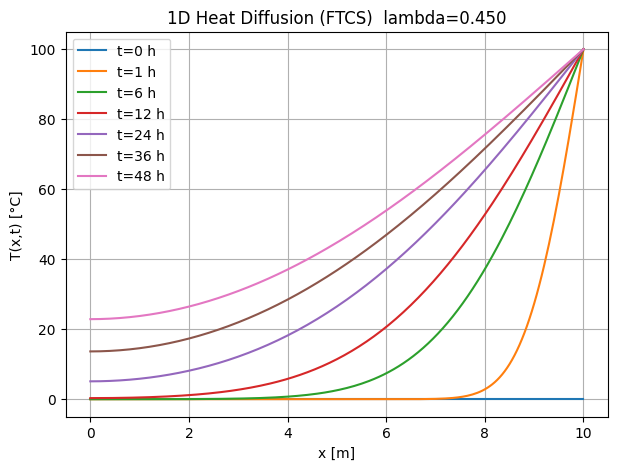

In [4]:
plt.figure(figsize=(7,5))
for ts in sorted(snapshots.keys()):
    plt.plot(x, snapshots[ts], label=f"t={ts/3600:.0f} h")
plt.xlabel("x [m]")
plt.ylabel("T(x,t) [°C]")
plt.title(f"1D Heat Diffusion (FTCS)  lambda={lam:.3f}")
plt.grid(True)
plt.legend()
plt.show()